In [1]:
!pip install xgboost

##Importing the necessary libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
states_df = pd.read_csv('df_states_only.csv')
admissions_df = pd.read_csv('weekly_avg_admissions_from_daily.csv')
display(states_df.head())
display(admissions_df.head())

,states,number_hospitals_reporting_today,total_hospitals,admissions_all_covid_confirmed,admissions_70_covid_confirmed,admissions_30_49_covid_confirmed,admissions_50_69_covid_confirmed,admissions_18_29_covid_confirmed,average_admissions_all_covid_confirmed,average_admissions_18_29_covid_confirmed,...,absolute_change_average_percent_staff_adult_icu_beds_occupied,absolute_change_average_percent_staff_pediatric_icu_beds_occupied,year_month,month,covid_admissions_young,covid_admissions_middle_aged,covid_admissions_geriatric,young,middle_aged,elderly
0,AZ,55.0,95.0,95.0,26.0,16.0,35.0,9.0,125.714286,8.571429,...,-4.678492,3.774523,2020-08,2020-08,9.0,51.0,26.0,9.0,51.0,26.0
1,AZ,76.0,95.0,124.0,29.0,24.0,34.0,5.0,123.428571,8.714286,...,-3.284308,-0.040802,2020-08,2020-08,5.0,58.0,29.0,5.0,58.0,29.0
2,AZ,82.0,95.0,100.0,26.0,21.0,28.0,8.0,123.428571,9.285714,...,-2.437162,-8.305584,2020-08,2020-08,8.0,49.0,26.0,8.0,49.0,26.0
3,AZ,81.0,95.0,121.0,32.0,23.0,32.0,13.0,120.571429,9.571429,...,-1.014152,-5.207254,2020-08,2020-08,13.0,55.0,32.0,13.0,55.0,32.0
4,AZ,84.0,95.0,120.0,27.0,28.0,35.0,8.0,118.285714,9.571429,...,-0.110215,-5.779696,2020-08,2020-08,8.0,63.0,27.0,8.0,63.0,27.0


,collection_date,average_admissions_all_covid_confirmed
0,2020-08-02,101.007003
1,2020-08-09,93.713085
2,2020-08-16,84.008003
3,2020-08-23,83.309724
4,2020-08-30,77.724690


####***XGBOOST regressor is somewhat robust to outliers, since it utilizes a tree-based algorithm which split data based on feature values rather than weighted combinations we shall log-transform the data instead of performing scaling.***
***Log-transformation, essentially compresses the large values and expands the small values. This creates a more balanced distribution that allows the tree-based algorithm to make more nuanced splits across the entire range of your data, i.e the respiratory virus admissions data across different times and different seasons,might have many days with low admissions and occasional spikes during outbreaks. This creates a distribution where most values cluster near zero with some very large values. The data, therefore might seem highly skewed***      

In [4]:
#Log transform
num_cols_states = states_df.select_dtypes(include=['number']).columns.tolist()
num_cols_states = states_df.select_dtypes(include=['number']).columns.tolist()
num_cols_admissions = admissions_df.select_dtypes(include=['number']).columns.tolist()
# Apply log1p transform
log_states = states_df.copy()
log_states[num_cols_states] = np.log1p(log_states[num_cols_states])
log_admin = admissions_df.copy()
log_admin[num_cols_admissions] = np.log1p(log_admin[num_cols_admissions])

####****Creating functions for a pipeline to minimize data leaks****

In [5]:
def temporal_features_for_covid_admissions(admissions_df, target_col='average_admissions_all_covid_confirmed', lookback_periods=8):
    """
    Creating temporal features specifically for your COVID admissions data
    target_col: the admissions column we want to predict
    lookback_periods: how many weeks back to look (8 weeks = ~2 months of context)
    """

    data = admissions_df.copy()

    print("Examining date column format...")
    print(f"Sample dates: {data['collection_date'].head(3).tolist()}")
    print(f"Date column type: {data['collection_date'].dtype}")

    try:
        data['collection_date'] = pd.to_datetime(data['collection_date'])
        print("✓ Date conversion successful with automatic detection")
    except:
        try:
            data['collection_date'] = pd.to_datetime(data['collection_date'], format='%Y-%m-%d')
            print("✓ Date conversion successful with ISO format")
        except:
            data['collection_date'] = pd.to_datetime(data['collection_date'], format='mixed')
            print("✓ Date conversion successful with mixed format parsing")

    # Sorting by date to ensure proper temporal ordering
    data = data.sort_values('collection_date')

    # Reseting index to ensure clean sequential indexing after sorting
    data = data.reset_index(drop=True)

    print(f"Date range: {data['collection_date'].min()} to {data['collection_date'].max()}")
    print(f"Total time periods: {len(data)}")

    # Creating lagged features
    print("Creating lagged features...")
    for i in range(1, lookback_periods + 1):
        data[f'{target_col}_lag_{i}'] = data[target_col].shift(i)

    # Creating rolling statistics to capture trends and patterns
    print("Creating rolling window features...")
    for window in [2, 4, 8]:
        data[f'{target_col}_rolling_mean_{window}'] = data[target_col].rolling(window).mean()
        data[f'{target_col}_rolling_std_{window}'] = data[target_col].rolling(window).std()
        data[f'{target_col}_rolling_min_{window}'] = data[target_col].rolling(window).min()
        data[f'{target_col}_rolling_max_{window}'] = data[target_col].rolling(window).max()

    # Calculating percentage changes to capture growth/decline patterns
    print("Creating change and trend features...")
    data[f'{target_col}_pct_change_1week'] = data[target_col].pct_change(periods=1)
    data[f'{target_col}_pct_change_2week'] = data[target_col].pct_change(periods=2)
    data[f'{target_col}_pct_change_4week'] = data[target_col].pct_change(periods=4)

    # Creating seasonal features from the date
    print("Creating seasonal features...")
    data['week_of_year'] = data['collection_date'].dt.isocalendar().week
    data['month'] = data['collection_date'].dt.month
    data['quarter'] = data['collection_date'].dt.quarter
    data['year'] = data['collection_date'].dt.year

    # Creating cyclical features for seasonality
    data['week_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
    data['week_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

    # Remove rows with NaN values created by  transformations
    data_clean = data.dropna()

    print(f"\n📊 Feature Engineering Summary:")
    print(f"Original data shape: {admissions_df.shape}")
    print(f"After temporal features: {data_clean.shape}")
    print(f"New features created: {len([col for col in data_clean.columns if col not in admissions_df.columns])}")
    print(f"Data loss due to lags/rolling: {len(data) - len(data_clean)} rows")

    return data_clean

In [6]:
def aggregate_state_features(states_df):

    # Group by time period (adjust this based on your actual time column)
    # I'm assuming 'year_month' based on your column list
    if 'year_month' in states_df.columns:
        time_col = 'year_month'
    else:
        print("Warning: No clear time column found in states data")
        return states_df

    numeric_cols = states_df.select_dtypes(include=['number']).columns.tolist()

    # Removing identifier columns that shouldn't be aggregated
    exclude_cols = ['states'] if 'states' in numeric_cols else []
    agg_cols = [col for col in numeric_cols if col not in exclude_cols]

    # Create aggregate statistics across all states for each time period
    state_aggregates = states_df.groupby(time_col).agg({
        **{col: ['mean', 'std', 'min', 'max', 'sum'] for col in agg_cols[:10]},
        'states': 'count'
    }).round(4)

    state_aggregates.columns = [f"state_agg_{col[0]}_{col[1]}" if col[1] else f"state_agg_{col[0]}"
                               for col in state_aggregates.columns]

    # Reset index to make time_col a regular column
    state_aggregates = state_aggregates.reset_index()

    return state_aggregates

In [7]:
def complete_temporal_dataset(admissions_df, states_df, target_col='average_admissions_all_covid_confirmed'):
    """
    Creation of the complete dataset combining temporal admissions features with state aggregates
    """
    print("Creating temporal features from admissions data...")
    temporal_features = temporal_features_for_covid_admissions(
        log_admin,
        target_col=target_col,
        lookback_periods=6
    )
    print("Creating aggregate features from states data...")
    state_features = aggregate_state_features(log_states)  # Your log-transformed states data

    # Aligning time periods between datasets

    temporal_features['year_month'] = temporal_features['collection_date'].dt.to_period('M').astype(str)

    #  Merging the datasets
    print("Merging temporal and state features...")
    if 'year_month' in state_features.columns:
        complete_dataset = temporal_features.merge(
            state_features,
            on='year_month',
            how='left'  # Keep all temporal records, add state info where available
        )
        print(f"Successfully merged datasets. Final shape: {complete_dataset.shape}")
    else:
        print("Warning: Could not merge with state data. Using only temporal features.")
        complete_dataset = temporal_features

    return complete_dataset

In [8]:
# Applying the complete pipeline to the datasets
target_column = 'average_admissions_all_covid_confirmed'

# Create the complete temporal dataset
final_modeling_data = complete_temporal_dataset(
    admissions_df=log_admin,
    states_df=log_states,
    target_col=target_column
)

# Preparing features for XGBoost
# Excluding non-feature columns (dates, identifiers, target variable)
feature_cols = [col for col in final_modeling_data.columns
                if col not in ['collection_date', 'year_month', target_column]]

X = final_modeling_data[feature_cols]
y = final_modeling_data[target_column]

print(f"Final dataset ready for modeling:")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"Target variable: {target_column}")

Creating temporal features from admissions data...
Examining date column format...
Sample dates: ['2020-08-02', '2020-08-09', '2020-08-16']
Date column type: object
✓ Date conversion successful with automatic detection
Date range: 2020-08-02 00:00:00 to 2024-04-28 00:00:00
Total time periods: 196
Creating lagged features...
Creating rolling window features...
Creating change and trend features...
Creating seasonal features...

📊 Feature Engineering Summary:
Original data shape: (196, 2)
After temporal features: (189, 31)
New features created: 29
Data loss due to lags/rolling: 7 rows
Creating aggregate features from states data...
Merging temporal and state features...
Successfully merged datasets. Final shape: (189, 83)
Final dataset ready for modeling:
Features: 80
Samples: 189
Target variable: average_admissions_all_covid_confirmed


*****Using the normal train-test split might lead to data leakage through temporal relationships i.e we can not train our model using September 2024 data and trying to predict the admissions in January 2024.Moreover, timeseries data contains autocorrelation and temporal dependancies meaning today's events are strongly related with yesterday's events. We will therefore import a TimeSeries split*****

In [9]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,mean_absolute_percentage_error,make_scorer

In [10]:
tscv = TimeSeriesSplit(n_splits=10)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = XGBRegressor(n_estimators=500,
                         learning_rate=0.05,
                         max_depth=10,
                          gamma=0,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         objective='reg:squarederror',
                         tree_method='hist',
                         eval_metric=["rmse", "mae", "mape"],
                         random_state=42,
                         verbosity=1)
    model.fit(X_train, y_train)

In [11]:
y_pred = model.predict(X_test)

In [12]:
print(y_pred)

[4.54582   4.5383825 4.40144   4.241274  4.1374564 4.0530896 3.9798436
 3.9455957 3.8313537 3.7442017 3.5141232 3.3303277 3.2544982 3.1105313
 3.093803  2.9338398 2.9540746]


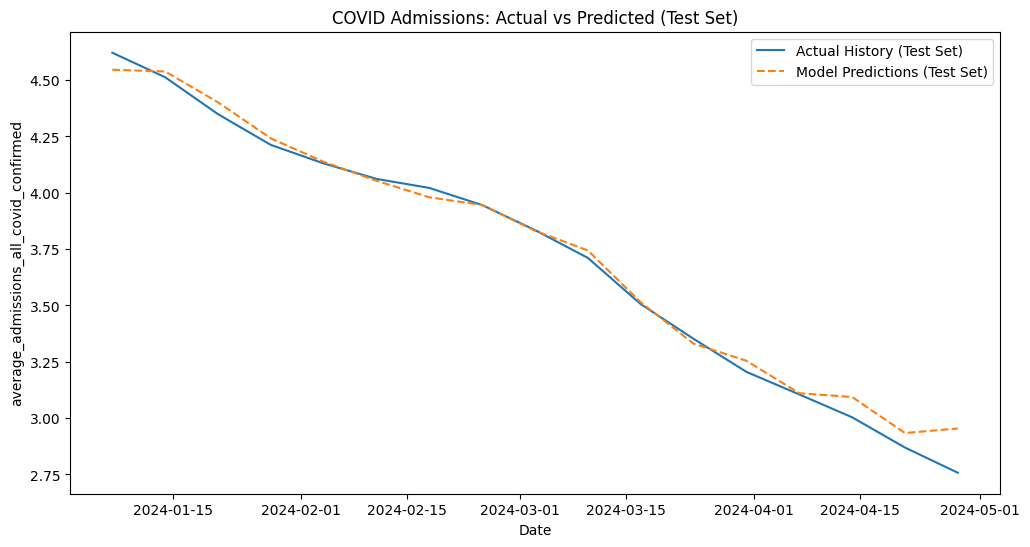

In [14]:
# Plotting the historical actuals vs the model predictions on the *test* set
plt.figure(figsize=(12,6))
# Get the corresponding dates for the test set from the original data
test_dates = final_modeling_data.iloc[test_index]['collection_date']
# Plot the actual historical data from the test set
plt.plot(test_dates, y_test, label='Actual History (Test Set)')
# Plot the model's predictions on the test set
plt.plot(test_dates, y_pred, label='Model Predictions (Test Set)', linestyle='--')
plt.legend()
plt.title('COVID Admissions: Actual vs Predicted (Test Set)') # Add a title for clarity
plt.xlabel('Date') # Add x-axis label
plt.ylabel(target_column) # Add y-axis label based on your target
plt.show()

***From the graph above:
There is a strong downward trend;over the 4-month test window (mid-January to the end of April 2024), average COVID admissions steadily fall while the fit seems excellent.The dashed orange “Model Predictions” line almost hugs the solid blue “Actual” line the whole way.Slight bias at the ends of the graphs shown early in January, the model slightly under-predicts (orange sits just below blue).And late in April, it very marginally over-predicts (orange just above blue).The prediction curve is also slightly smoother than the actuals, suggesting that the model generalizes well (and doesn't overfit), but may under-react to very sudden changes.***



In [15]:
last_date = final_modeling_data['collection_date'].max()

future_dates = pd.date_range(last_date + pd.Timedelta(1, 'W'),
                             periods=30, freq='W')

In [16]:
final_modeling_data.head()

,collection_date,average_admissions_all_covid_confirmed,average_admissions_all_covid_confirmed_lag_1,average_admissions_all_covid_confirmed_lag_2,average_admissions_all_covid_confirmed_lag_3,average_admissions_all_covid_confirmed_lag_4,average_admissions_all_covid_confirmed_lag_5,average_admissions_all_covid_confirmed_lag_6,average_admissions_all_covid_confirmed_rolling_mean_2,average_admissions_all_covid_confirmed_rolling_std_2,...,state_agg_average_admissions_18_29_covid_confirmed_std,state_agg_average_admissions_18_29_covid_confirmed_min,state_agg_average_admissions_18_29_covid_confirmed_max,state_agg_average_admissions_18_29_covid_confirmed_sum,state_agg_average_admissions_40_49_covid_confirmed_mean,state_agg_average_admissions_40_49_covid_confirmed_std,state_agg_average_admissions_40_49_covid_confirmed_min,state_agg_average_admissions_40_49_covid_confirmed_max,state_agg_average_admissions_40_49_covid_confirmed_sum,state_agg_states_count
0,2020-09-20,4.193346,4.247574,4.351916,4.365957,4.434497,4.442745,4.550852,4.220460,0.038345,...,0.7819,0.0,3.8471,1724.2220,1.4096,0.8811,0.0,4.0580,2156.6226,1530
1,2020-09-27,4.183390,4.193346,4.247574,4.351916,4.365957,4.434497,4.442745,4.188368,0.007040,...,0.7819,0.0,3.8471,1724.2220,1.4096,0.8811,0.0,4.0580,2156.6226,1530
2,2020-10-04,4.268720,4.183390,4.193346,4.247574,4.351916,4.365957,4.434497,4.226055,0.060338,...,0.7837,0.0,3.8098,2115.8512,1.7466,0.9187,0.0,4.3874,2761.3817,1581
3,2020-10-11,4.431050,4.268720,4.183390,4.193346,4.247574,4.351916,4.365957,4.349885,0.114785,...,0.7837,0.0,3.8098,2115.8512,1.7466,0.9187,0.0,4.3874,2761.3817,1581
4,2020-10-18,4.548170,4.431050,4.268720,4.183390,4.193346,4.247574,4.351916,4.489610,0.082816,...,0.7837,0.0,3.8098,2115.8512,1.7466,0.9187,0.0,4.3874,2761.3817,1581


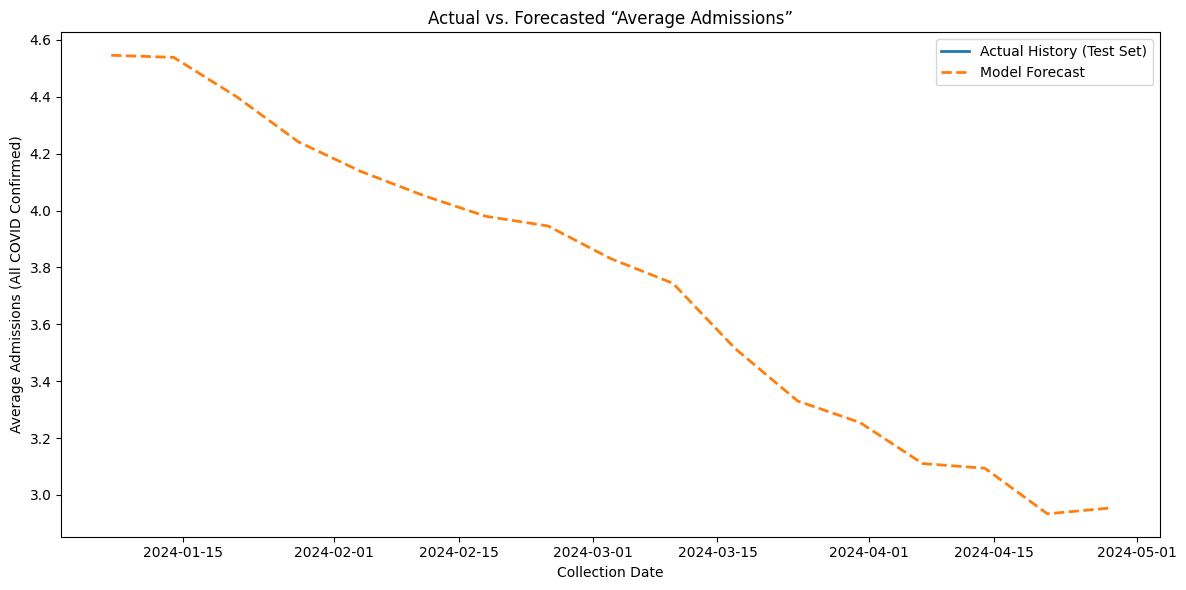

In [17]:
test_dates = pd.to_datetime(final_modeling_data.loc[test_index, 'collection_date'])

# 2) Create Series for neat plotting (optional but handy)
actual_series   = pd.Series(y_test,   index=test_dates, name='Actual')
forecast_series = pd.Series(y_pred,    index=test_dates, name='Forecast')

# 3) Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_series,   label='Actual History (Test Set)', linewidth=2)
plt.plot(forecast_series, label='Model Forecast',          linestyle='--', linewidth=2)
plt.title("Actual vs. Forecasted “Average Admissions”")
plt.xlabel("Collection Date")
plt.ylabel("Average Admissions (All COVID Confirmed)")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# RMSE:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# MAE:
mae = mean_absolute_error(y_test, y_pred)

# MAPE:
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.2%}")

RMSE: 0.063, MAE: 0.042, MAPE: 1.26%


***The XGBOOST regressor performed fairly well, having a root mean square error of 0.063, meaning the total admissions predicted were off by about 0.063 admissions per hospital give or take. The mean absolute percentage error was 1.26%, meaning our predictions were roughly 1.3% from the actual values.The model however had an error of 0.042 admissions per hospital.***